In [ ]:
# https://github.com/Weronikaaa/AIML
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# === USTAWIENIA PARAMETRÓW MODELU ===

IMG_SIZE = 224                          # rozmiar obrazu (224x224 -standard ImageNet)
input_shape = (IMG_SIZE, IMG_SIZE, 3)   # 3 kanały = RGB - MobileNetV2 -nie obsługuje grayscale
num_classes = 3                         # ile klas klasyfikujemy - podany by model wiedział ile neuronów w warstwie wyjściowej ma utworzyć
learning_rate = 1e-4                    # współczynnik uczenia (dla optymalizatora Adam) dość małe by zapenić stabilne uczenie


In [ ]:
# === FUNKCJE POMOCNICZE: TRENING | ZAPIS | WIZUALIZACJA ===

def plot_history(history, out_dir="plots", prefix="model"):                 # Tworzy i zapisuje wykresy dokładności (accuracy) i straty (loss) na zbiorze treningowym i walidacyjnym
    os.makedirs(out_dir, exist_ok=True)
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_accuracy.png")
    plt.close()

    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_loss.png")
    plt.close()

def plot_conf_matrix(model, generator, out_dir="plots", prefix="model"):    # Tworzy macierz pomyłek (confusion matrix) i zapisuje ją jako obraz oraz zapisuje raport klasyfikacji do pliku tekstowego
    os.makedirs(out_dir, exist_ok=True)
    y_true, y_pred = [], []
    class_names = list(generator.class_indices.keys())
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))   # prawdziwe etykiety
        y_pred.extend(np.argmax(preds, axis=1))     # przewidziane etykiety

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_confusion.png")
    plt.close()

    report = classification_report(y_true, y_pred, target_names=class_names)
    with open(f"{out_dir}/{prefix}_classification_report.txt", "w") as f:
        f.write(report)

def save_history(history, filename):    # zapisuje dane w json
    with open(filename, "w") as f:
        json.dump(history.history, f)

def train_model(model, model_name, train_gen, val_gen, epochs=30):
    print(f"\n== Training {model_name} ==\n")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),   # przerwanie trenowania, jeśli val_loss się nie poprawia przez 3 epoki
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),              # jak val_loss się nie poprawia przez 2 epoki, zmniejsza learning rate o połowę
        ModelCheckpoint(f"models/{model_name}.keras", save_best_only=True)          # zapisuje najlepszy model do pliku
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    plot_history(history, out_dir="plots", prefix=model_name)
    plot_conf_matrix(model, val_gen, out_dir="plots", prefix=model_name)
    save_history(history, f"plots/{model_name}_history.json")
    model.save(f"models/{model_name}_final.keras")
    return history

def plot_comparison(histories, metric="accuracy", out_file="comparison.png"):
    plt.figure(figsize=(7, 5))
    for name, hist in histories.items():
        plt.plot(hist[metric], label=f"{name} train")
        plt.plot(hist["val_" + metric], label=f"{name} val", linestyle="--")
    plt.title(f"Comparison: {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/{out_file}")
    plt.close()

In [8]:
# === KATALOGI NA MODELE I WYKRESY ===
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

In [ ]:
# === WCZYTANIE DNAYCH I AUGMENTACJA ===
train_datagen = ImageDataGenerator(     
    rescale=1./255,             # Przeskalowuje piksele z zakresu [0, 255] → [0, 1] (normalizacja)
    rotation_range=25,          # Losowo obraca obraz w zakresie ±25°
    width_shift_range=0.2,      # Przesuwa obraz poziomo o maksymalnie 20% szerokości
    height_shift_range=0.2,     # Przesuwa obraz pionowo o maks. 20% wysokości
    zoom_range=0.2,             # Zoomuje w obraz losowo o ±20%
    horizontal_flip=True,       # Odbija obraz poziomo (np. lustrzanie)
    fill_mode='nearest'         # Wypełnia nowe piksele po transformacji najbliższymi wartościami
)
val_datagen = ImageDataGenerator(rescale=1./255)        # Walidacja jest jedynie normalizowana

train_generator = train_datagen.flow_from_directory(    # Wczytuje obrazy treningowe z katalogu
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(        # Wczytuje obrazy walidacyjne  z katalogu
    'dataset/valid',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

Found 8393 images belonging to 3 classes.
Found 2277 images belonging to 3 classes.


In [ ]:
# === MODEL CNN ===
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),      # 32 filtry 3x3, aktywacja ReLU
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),                               # 64 filtry 3x3, aktywacja ReLU
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),                                                          # spłaszczenie danych z 2D do 1D
    Dropout(0.3),                                                       # losowe "wyłączanie" 30% neuronów
    Dense(128, activation='relu'),                                      # 128 neuronów, aktywacja ReLU
    Dense(num_classes, activation='softmax')                            # klasyfikacja do liczby klas
])

cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_history = train_model(cnn_model, "CNN", train_generator, val_generator)

c:\Users\Weron\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



== Training CNN ==



c:\Users\Weron\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.7819 - loss: 1.3535 - val_accuracy: 0.3224 - val_loss: 13.3667 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 767s 3s/step - accuracy: 0.8814 - loss: 0.3158 - val_accuracy: 0.8472 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.9002 - loss: 0.2499 - val_accuracy: 0.8735 - val_loss: 0.3382 - learning_rate: 1.0000e-04
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.9078 - loss: 0.2374 - val_accuracy: 0.8955 - val_loss: 0.3098 - learning_rate: 1.0000e-04
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.9217 - loss: 0.2030 - val_accuracy: 0.8173 - val_loss: 0.7958 - learning_rate: 1.0000e-04
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.9186 - loss: 0.2024 - val_accuracy: 0.8981 - val_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - ac

In [11]:
# === MODEL MOBILENETV2 ===
mobilenet_base = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
mobilenet_base.trainable = False

mobilenet_model = Sequential([
    mobilenet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

mobilenet_model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_history = train_model(mobilenet_model, "MobileNetV2", train_generator, val_generator)



== Training MobileNetV2 ==

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.4951 - loss: 1.0489 - val_accuracy: 0.7339 - val_loss: 0.6508 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.7595 - loss: 0.6011 - val_accuracy: 0.8041 - val_loss: 0.5008 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 251s 956ms/step - accuracy: 0.8140 - loss: 0.4820 - val_accuracy: 0.8415 - val_loss: 0.4146 - learning_rate: 1.0000e-04
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 246s 935ms/step - accuracy: 0.8432 - loss: 0.4149 - val_accuracy: 0.8709 - val_loss: 0.3565 - learning_rate: 1.0000e-04
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8585 - loss: 0.3677 - val_accuracy: 0.8911 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 256s 974ms/step - accuracy: 0.8807 - loss: 0.3338 - val_accuracy: 0.8999 - val_loss: 0.2882 - learning_rate: 1.0000e-04
Epoch 7/30
263/263 ━

In [28]:
# === MODEL MOBILENETV2 + FINE-TUNING ===
fine_tune_base = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
fine_tune_base.trainable = True
for layer in fine_tune_base.layers[:-20]:
    layer.trainable = False

mobilenet_finetune_model = Sequential([
    fine_tune_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

mobilenet_finetune_model.compile(optimizer=Adam(learning_rate=1e-5),
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

mobilenet_finetune_history = train_model(mobilenet_finetune_model, "MobileNetV2_FineTuned", train_generator, val_generator)


== Training MobileNetV2_FineTuned ==

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.5910 - loss: 0.8881 - val_accuracy: 0.8801 - val_loss: 0.3909 - learning_rate: 1.0000e-05
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.8779 - loss: 0.3481 - val_accuracy: 0.9117 - val_loss: 0.2581 - learning_rate: 1.0000e-05
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.9087 - loss: 0.2446 - val_accuracy: 0.9306 - val_loss: 0.1921 - learning_rate: 1.0000e-05
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.9229 - loss: 0.2089 - val_accuracy: 0.9407 - val_loss: 0.1636 - learning_rate: 1.0000e-05
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.9370 - loss: 0.1698 - val_accuracy: 0.9526 - val_loss: 0.1320 - learning_rate: 1.0000e-05
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9392 - loss: 0.1651 - val_accuracy: 0.9596 - val_loss: 0.1133 - learning_rate: 1.0000e-05
Epoch 7/30
263/263 

In [ ]:
# === PORÓWNANIE MODELI ===
with open("plots/CNN_history.json") as f1, open("plots/MobileNetV2_history.json") as f2, open("plots/MobileNetV2_FineTuned_history.json") as f3:
    cnn_hist = json.load(f1)
    mobilenet_hist = json.load(f2)
    finetune_hist = json.load(f3)

plot_comparison({
    "CNN": cnn_hist,
    "MobileNetV2": mobilenet_hist,
    "MobileNetV2_FT": finetune_hist
}, metric="accuracy", out_file="comparison_accuracy.png")

plot_comparison({
    "CNN": cnn_hist,
    "MobileNetV2": mobilenet_hist,
    "MobileNetV2_FT": finetune_hist
}, metric="loss", out_file="comparison_loss.png")

In [13]:
def count_images_per_class(base_dir):
    counts = {}
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        split_counts = {}
        for class_name in sorted(os.listdir(split_dir)):
            class_dir = os.path.join(split_dir, class_name)
            num_images = len(os.listdir(class_dir))
            split_counts[class_name] = num_images
        counts[split] = split_counts
    return counts

def plot_image_counts(counts):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, split in enumerate(['train', 'valid', 'test']):
        class_names = list(counts[split].keys())
        values = list(counts[split].values())
        axes[i].bar(class_names, values, color='skyblue')
        axes[i].set_title(f"{split.capitalize()} set")
        axes[i].set_xlabel("Class")
        axes[i].set_ylabel("# Images")
        for idx, val in enumerate(values):
            axes[i].text(idx, val + 1, str(val), ha='center')
    plt.tight_layout()
    plt.savefig("plots/image_distribution.png")
    plt.close()

# === LICZENIE I WIZUALIZACJA OBRAZÓW W KLASACH ===
counts = count_images_per_class("dataset")
plot_image_counts(counts)

In [46]:
import json
import pandas as pd

def generate_metrics_table(history_paths):
    data = {
        "Model": [],
        "Best Val Accuracy": [],
        "Best Val Loss": [],
        "Last Train Accuracy": [],
        "Last Train Loss": []
    }

    for model_name, path in history_paths.items():
        with open(path, "r") as f:
            hist = json.load(f)
        
        best_val_acc = max(hist.get("val_accuracy", [0]))
        best_val_loss = min(hist.get("val_loss", [0]))
        last_train_acc = hist.get("accuracy", [0])[-1]
        last_train_loss = hist.get("loss", [0])[-1]

        data["Model"].append(model_name)
        data["Best Val Accuracy"].append(round(best_val_acc * 100, 2))
        data["Best Val Loss"].append(round(best_val_loss, 4))
        data["Last Train Accuracy"].append(round(last_train_acc * 100, 2))
        data["Last Train Loss"].append(round(last_train_loss, 4))

    df = pd.DataFrame(data)
    return df

history_files = {
    "CNN": "plots/CNN_history.json",
    "MobileNetV2": "plots/MobileNetV2_history.json",
    "MobileNetV2_FT": "plots/MobileNetV2_FineTuned_history.json"
}

metrics_df = generate_metrics_table(history_files)
print(metrics_df)



            Model  Best Val Accuracy  Best Val Loss  Last Train Accuracy  \
0             CNN              89.81         0.3098                92.92   
1     MobileNetV2              94.69         0.1475                92.64   
2  MobileNetV2_FT              98.38         0.0529                98.09   

   Last Train Loss  
0           0.1645  
1           0.1950  
2           0.0534  


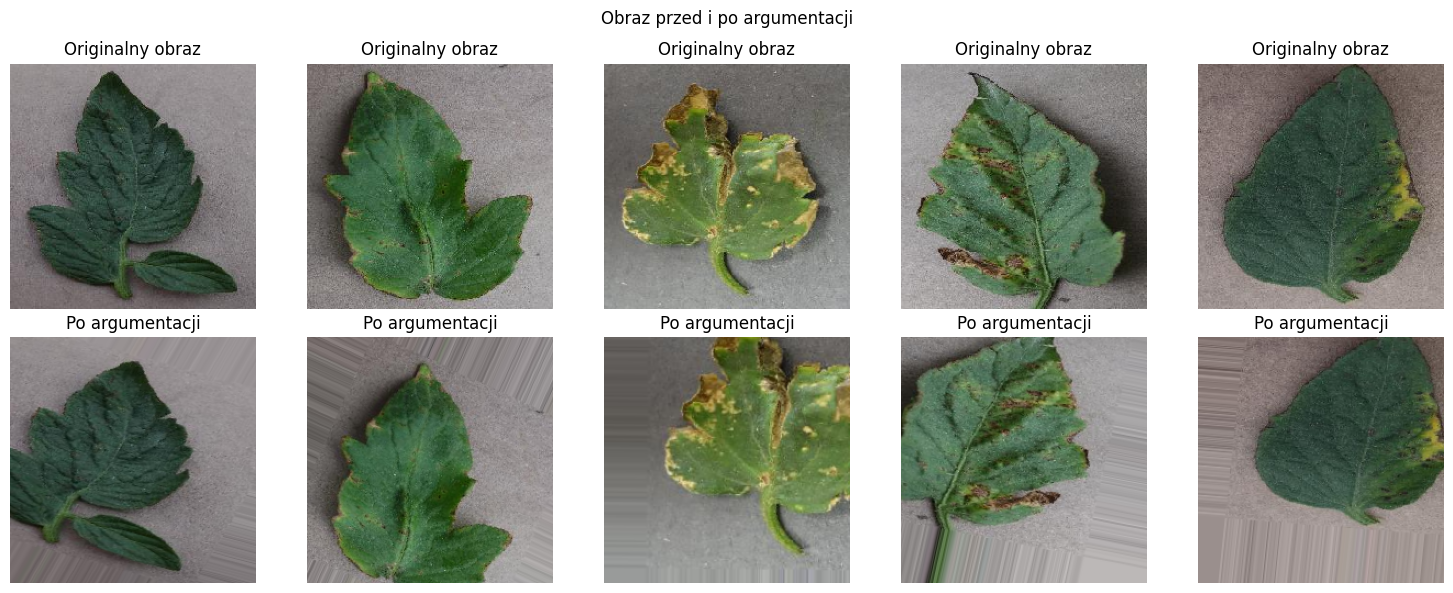

In [51]:
from tensorflow.keras.preprocessing import image

def show_true_augmentation(datagen, dataset_path, class_label=None, num_samples=5):
    from tensorflow.keras.preprocessing.image import img_to_array, load_img

    class_dir = os.path.join(dataset_path, class_label) if class_label else dataset_path
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))][:num_samples]

    plt.figure(figsize=(15, 6))
    for i, fname in enumerate(image_files):
        img_path = os.path.join(class_dir, fname)
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, 0)

        augmented_iter = datagen.flow(img_array, batch_size=1)
        augmented_img = next(augmented_iter)[0]

        # Orginalny obraz
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Originalny obraz")
        plt.axis('off')

        # Obraz po Argumentacji
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(augmented_img)
        plt.title("Po argumentacji")
        plt.axis('off')

    plt.suptitle("Obraz przed i po argumentacji")
    plt.tight_layout()
    plt.savefig("plots/true_augmentation.png")
    plt.show()

# === POKAŻ PRZED I PO AUGMENTACJI ===
show_true_augmentation(train_datagen, 'dataset/train/Bacterial_spot', class_label=None, num_samples=5)


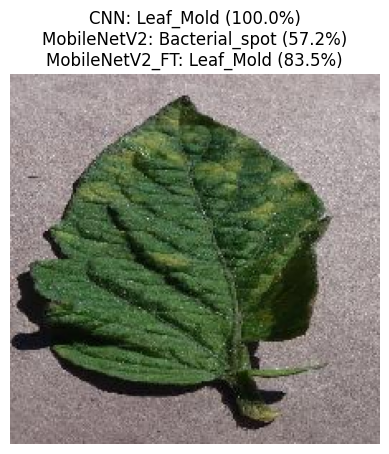


Obrazek: dataset/test\Leaf_Mold\2b31c158-d7d5-4625-b13b-e3e626d791ff___Crnl_L.Mold 6665.JPG

=== CNN ===
Pred: Leaf_Mold (100.00%)
 - Bacterial_spot: 0.00%
 - Leaf_Mold: 100.00%
 - healthy: 0.00%

=== MobileNetV2 ===
Pred: Bacterial_spot (57.20%)
 - Bacterial_spot: 57.20%
 - Leaf_Mold: 39.02%
 - healthy: 3.77%

=== MobileNetV2 Fine-Tuned ===
Pred: Leaf_Mold (83.54%)
 - Bacterial_spot: 3.45%
 - Leaf_Mold: 83.54%
 - healthy: 13.01%


In [ ]:
import random

# === PREDYKCJA LOSOWEGO ZDJĘCIA Z TEST SETU ===
def predict_random_image_with_all_models(test_dir, cnn_model_path, mobilenet_model_path, mobilenet_ft_model_path, class_indices):
    all_classes = os.listdir(test_dir)
    chosen_class = random.choice(all_classes)
    class_path = os.path.join(test_dir, chosen_class)
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Ładuje modele
    cnn_model = tf.keras.models.load_model(cnn_model_path)
    mobilenet_model = tf.keras.models.load_model(mobilenet_model_path)
    mobilenet_ft_model = tf.keras.models.load_model(mobilenet_ft_model_path)

    class_names = [cls for cls, idx in sorted(class_indices.items(), key=lambda x: x[1])]

    # Predykcje
    cnn_pred = cnn_model.predict(img_array, verbose=0)[0]
    mobilenet_pred = mobilenet_model.predict(img_array, verbose=0)[0]
    ft_pred = mobilenet_ft_model.predict(img_array, verbose=0)[0]

    # Najbardziej prawdopodobne klasy
    cnn_class = class_names[np.argmax(cnn_pred)]
    cnn_conf = np.max(cnn_pred) * 100

    mobilenet_class = class_names[np.argmax(mobilenet_pred)]
    mobilenet_conf = np.max(mobilenet_pred) * 100

    ft_class = class_names[np.argmax(ft_pred)]
    ft_conf = np.max(ft_pred) * 100

    # Wyświetlenie obrazu z tytułem
    plt.imshow(img)
    plt.title(
        f"CNN: {cnn_class} ({cnn_conf:.1f}%)\n"
        f"MobileNetV2: {mobilenet_class} ({mobilenet_conf:.1f}%)\n"
        f"MobileNetV2_FT: {ft_class} ({ft_conf:.1f}%)"
    )
    plt.axis('off')
    plt.show()

    print(f"\nObrazek: {image_path}")
    print(f"\n=== CNN ===")
    print(f"Pred: {cnn_class} ({cnn_conf:.2f}%)")
    for i, prob in enumerate(cnn_pred):
        print(f" - {class_names[i]}: {prob*100:.2f}%")

    print(f"\n=== MobileNetV2 ===")
    print(f"Pred: {mobilenet_class} ({mobilenet_conf:.2f}%)")
    for i, prob in enumerate(mobilenet_pred):
        print(f" - {class_names[i]}: {prob*100:.2f}%")

    print(f"\n=== MobileNetV2 Fine-Tuned ===")
    print(f"Pred: {ft_class} ({ft_conf:.2f}%)")
    for i, prob in enumerate(ft_pred):
        print(f" - {class_names[i]}: {prob*100:.2f}%")

predict_random_image_with_all_models(
    "dataset/test",
    "models/CNN_final.keras",
    "models/MobileNetV2_final.keras",
    "models/MobileNetV2_FineTuned_final.keras",
    train_generator.class_indices
)
